# import package

In [8]:
# Import Package
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import random
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.feature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.colors as colors
import cartopy.feature as cfeature
from scipy.stats import norm
from scipy.stats import laplace
import matplotlib as mpl
from scipy import stats
import os
from scipy import optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx
import xarray as xr

# Urban-rural differences in light precipitation frequency and extreme precipitation magnitude (satellite-based result for DI)

## Location of studied cities

(465, 2)


<Axes: >

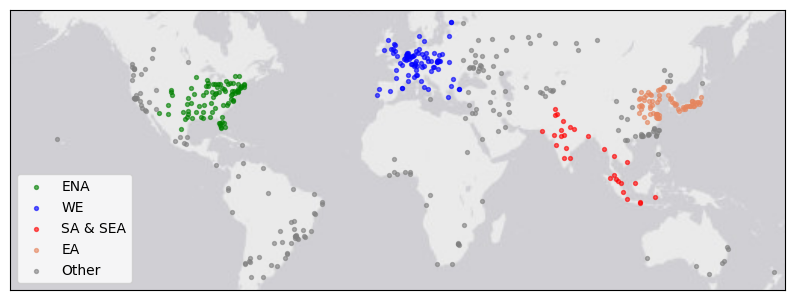

In [9]:
# process data into proper data frame

# spatial location
loc = np.loadtxt(r"loc.txt")
df_loc = pd.DataFrame(loc, columns=["lon", "lat"])

print(df_loc.shape)
def classify_location(row):
    lon, lat = row["lon"], row["lat"]
    if -111 <= lon <= -59 and 24 <= lat <= 48:
        return "ENA"
    elif -30 <= lon <= 30 and 38 <= lat <= 65:
        return "WE"
    elif 60 <= lon <= 90 and -10 <= lat <= 35:
        return "SA & SEA"
    elif 90 <= lon <= 120 and -20 <= lat <= 20:
        return "SA & SEA"
    elif 111 <= lon <= 142 and 28 <= lat <= 43:
        return "EA"
    else:
        return "Other"
df_loc["category"] = df_loc.apply(classify_location,axis=1)
category_colors = {
    "ENA": (69/255,42/255,61/255),
    "WE": (68/255,117/255,122/255),
    "SA & SEA": (212/255,76/255,60/255),
    "EA": (229/255,133/255,93/255),
    "Other": "grey"
}
category_colors = {
    "ENA": "g",
    "WE": "b",
    "SA & SEA": "r",
    "EA": (229/255,133/255,93/255),
    "Other": "grey"
}

# convert this into geoseries
gdf_loc = gpd.GeoDataFrame(
    df_loc,
    geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)
w, s, e, n = gdf_loc.total_bounds
# w, s, e, n

def spatial_show_category(ax):
    for category, color in category_colors.items():
        gdf_loc[gdf_loc["category"] == category].plot(
            ax=ax,
            markersize=8,
            color=color,
            alpha=0.6,
            label=category
        )
    ctx.add_basemap(
        ax=ax,
        attribution="",
        source=ctx.providers.Esri.WorldGrayCanvas,
    )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.autoscale(axis='x')
    ax.legend(loc = r"lower left",fontsize = 10)
    return ax
fig, ax = plt.subplots(figsize=(10, 10))
spatial_show_category(ax)



## spatial pattern of DI

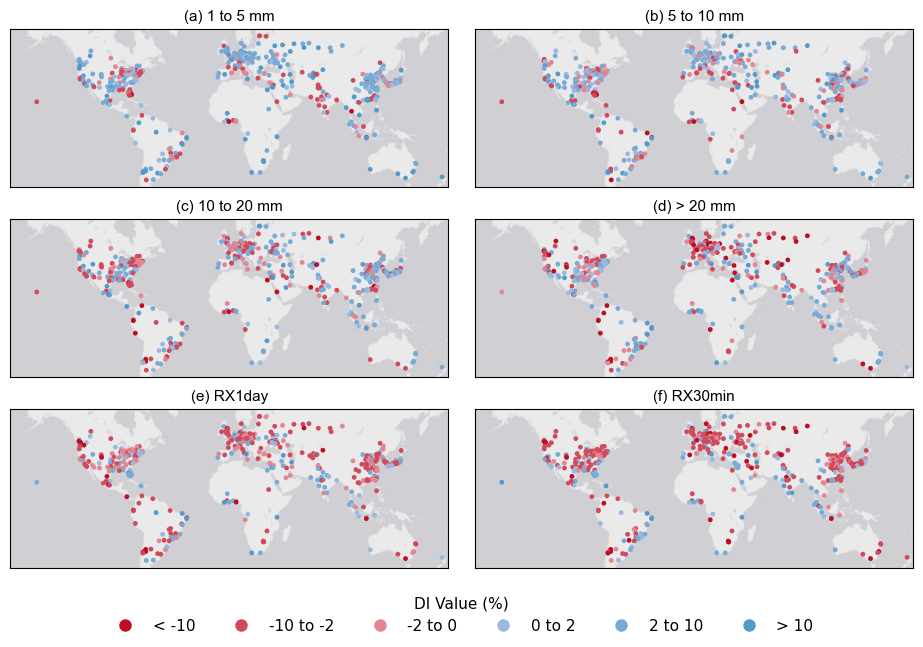

In [10]:
def blend_colors(color1, color2, blend_factor):
    """
    Blend two colors together.

    Parameters:
    - color1: The first color in RGB tuple format (e.g., (1, 0, 0) for red).
    - color2: The second color in RGB tuple format (e.g., (0, 0, 1) for blue).
    - blend_factor: A float between 0 and 1 that determines the blend proportion.

    Returns:
    - Blended color in RGB tuple format.
    """
    return tuple(
        (
            (1 - blend_factor) * np.array(color1) + blend_factor * np.array(color2)
        ).tolist()
    )


# time series of difference index
# 1. annual frequency of precipitation days of different intensity
import numpy as np
to5 = np.loadtxt(r"DI_data/result_1-5.txt")
to10 = np.loadtxt(r"DI_data/result_5-10.txt")
to20 = np.loadtxt(r"DI_data/result_10-20.txt")
over20 = np.loadtxt(r"DI_data/result_wet_day20.txt")

# 2. maximum precipitation of different time scale
daymax = np.loadtxt(r"DI_data/result_daymax1.txt")
hourmax = np.loadtxt(r"DI_data/result_hourmax.txt")

# process data in arrays into proper data frame
dict_ar_di = {
    "1 to 5mm": to5,
    "5 to 10mm": to10,
    "10 to 20mm": to20,
    "> 20mm": over20,
    "RX1day": daymax,
    "RX30min": hourmax,
}

# create data frame
dict_df_di = {}
# idx_loc = pd.Index(loc, name = "coords")
for key in dict_ar_di:
    dict_df_di[key] = pd.DataFrame(
        dict_ar_di[key],
        columns=pd.DatetimeIndex(
            pd.date_range("2001-1-1", "2021-1-1", freq="YE"),
            name="year",
        ),
    )
# pack all data frame into one
df_di = pd.concat(dict_df_di, axis=1,names=["di","year"])
df_di.index.rename("city", inplace=True)

# Define two colours in RGB format
color5 = (83 / 255, 154 / 255, 203 / 255)
color4 = (154 / 255, 185 / 255, 223 / 255)
color2 = (225 / 255, 135 / 255, 147 / 255)
color1 = (190 / 255, 13 / 255, 35 / 255)
blend_factors = np.linspace(0, 1, 3)
color_list =  [blend_colors(color1, color2, bf) for bf in blend_factors] + [blend_colors(color4, color5, bf) for bf in blend_factors] 

# spatial analysis of difference index
df_di_sel = (
    df_di.stack("di", future_stack=True)
    .median(axis=1)
    .unstack("di")
    .assign(geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),))
# construct a geodataframe
gdf_di_sel = gpd.GeoDataFrame(
    df_di_sel,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)
index_name = ["1 to 5mm","5 to 10mm","10 to 20mm","> 20mm","RX1day","RX30min"]
title_name = ["A. 1 to 5mm","B. 5 to 10mm","C. 10 to 20mm","D. > 20mm","E. RX1day","F. RX30min"]

intervals = [-9999, -0.1, -0.02,0,0.02, 0.1, 9999]

def map_intervals_to_colors(series, intervals, colorlist):
    return pd.cut(series, bins=intervals, labels=colorlist, include_lowest=True)

color_df = gdf_di_sel.iloc[:, :-1].apply(map_intervals_to_colors, intervals=intervals, colorlist=color_list)
color_df = (
    color_df
    .assign(geometry=gpd.points_from_xy(df_loc.lon, df_loc.lat),))
color_df = gpd.GeoDataFrame(
    color_df,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)
def plot_map(ax,data = color_df["1 to 5mm"]):
    color_df.plot(
        ax=ax,
        markersize=6,
        color=data)
    ctx.add_basemap(
        ax=ax,
        attribution="",
        source=ctx.providers.Esri.WorldGrayCanvas,
        # source=ctx.providers.CartoDB.DarkMatterNoLabels,
        # source=ctx.providers.Esri.WorldTopoMap,
        # source="https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}"
    )
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.autoscale(axis="x")
    return ax

index_name = ["1 to 5mm","5 to 10mm","10 to 20mm","> 20mm","RX1day","RX30min"]
title_name = ["(a) 1 to 5 mm","(b) 5 to 10 mm","(c) 10 to 20 mm","(d) > 20 mm","(e) RX1day","(f) RX30min"]

fig, axes = plt.subplots(
    3,
    2,
    figsize=(14,7),
)

fig.subplots_adjust(wspace=-0.25, hspace=0.2)
ax1,ax2,ax3,ax4,ax5,ax6 = axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1]
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
for i in range(6):
    axlist[i] = plot_map(axlist[i],color_df[index_name[i]])
    axlist[i].set_title(title_name[i],fontsize=11, fontfamily="Arial")
handles = []
unique_colors = {color_list[0]: '< -10', color_list[1]: '-10 to -2', color_list[2]: '-2 to 0',
                 color_list[3]: '0 to 2', color_list[4]: '2 to 10', color_list[5]: '> 10'}  
for color, label in unique_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markersize=10, markerfacecolor=color))
fig.legend(handles=handles,loc='lower center',ncol=6, title="DI Value (%)",frameon=0,fontsize=11,title_fontsize=11)


## Time series of DI

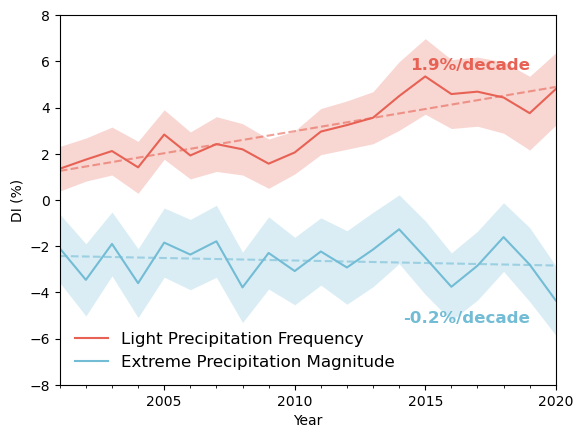

In [11]:
c_light_asc = np.array([231, 98, 84]) / 255
c_extreme_asc = np.array([114, 188, 213]) / 255
def compute_median_ci(data, confidence=0.95):
    n = len(data)
    median = np.median(data)
    stderr = stats.sem(data, ddof=1)
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    return median - margin_of_error, median + margin_of_error
def plot_trend(ax):
    dict_df_colour = {
        "light": [df_di["1 to 5mm"], c_light_asc, "Light Precipitation Frequency"],
        "extreme": [df_di["RX30min"], c_extreme_asc, "Extreme Precipitation Magnitude"],
    }
    for type, (df_type, c_type, lbl_type) in dict_df_colour.items():
        # calculate the confidence intervals
        ci_low, ci_up = [], []
        for col in df_type.columns:
            low, up = compute_median_ci(df_type[col].dropna())
            ci_low.append(low)
            ci_up.append(up)
        ci_low = pd.Series(ci_low, index=df_type.columns)
        ci_up = pd.Series(ci_up, index=df_type.columns)

        ser_median = df_type.median() * 100
        # calculate the trend of median
        slope, intercept = np.polyfit(ser_median.index.year, ser_median, 1)
        ser_trend = pd.Series(
            slope * ser_median.index.year + intercept, index=ser_median.index
        ).rename(None)

        # Plot the median
        ax1 = ser_median.plot(color=c_type, label=lbl_type, ylabel=r"DI (%)")
        # fill with condidence interval
        _ = ax.fill_between(
            ser_median.index,
            ci_low * 100,
            ci_up * 100,
            color=c_type,
            alpha=0.26,
            lw=0,
        )

        # Plot the trend
        _ = ser_trend.plot(ax=ax, linestyle="--", color=c_type, alpha=0.6)

        # Plot the trend text
        i_pos = -2
        ser_quantile = (
            df_type.quantile(0.55, axis=0).T * 100
            if type == "light"
            else df_type.quantile(0.45, axis=0).T * 100
        )
        _ = ax.text(
            ser_median.index[i_pos],
            ser_quantile.iloc[i_pos],
            f"{slope*10:.1f}%/decade",
            ha="right",
            va="bottom" if type == "light" else "top",
            color=c_type,
            fontweight="bold",
            fontsize=12,
        )
        
        
   
    ax.set_ylabel("DI (%)", color="k",fontsize=10,)
    ax.set_xlabel("Year", color="k",fontsize=10,)
    ax.set_ylim(-8,8)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.legend(frameon = False, loc = "lower left",fontsize=12,)
    return ax


fig, ax = plt.subplots()
ax = plot_trend(ax)

## Overall DI across precipitation indices

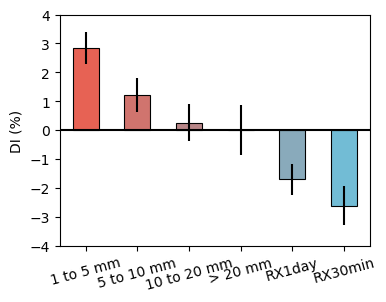

In [12]:
# Define two colours in RGB format
c_light_asc = np.array([231, 98, 84]) / 255
c_extreme_asc = np.array([114, 188, 213]) / 255

# Blend the colours with different blend factors
blend_factors = np.linspace(0, 1, 6)
blended_colors = [blend_colors(c_light_asc, c_extreme_asc, bf) for bf in blend_factors]



df_di_median = df_di.stack("di", future_stack=True).median(axis=1).unstack("di").median() * 100
df_di_median = df_di_median.rename(
        {
            "1 to 5mm": "1 to 5 mm",
            "5 to 10mm": "5 to 10 mm",
            "10 to 20mm": "10 to 20 mm",
            "> 20mm": "> 20 mm",

        })
#calculate the error bar by using the 95% confident interval
def compute_median_ci(data, confidence=0.95):
    n = len(data)
    median = np.median(data)
    stderr = stats.sem(data, ddof=1)
    margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    return median - margin_of_error, median + margin_of_error
df_di_bar = df_di.stack("di", future_stack=True)
error_dict = {
    'di': [],
    'ci_low': [],
    'ci_up': []
}

for di_key, group in df_di_bar.groupby('di',sort=False):
    data = group.stack()
    data.fillna(-9999)
    data.replace([np.inf, -np.inf], -9999, inplace=True)
    ci_low, ci_up = compute_median_ci(data[data!=-9999])
    error_dict['di'].append(di_key)
    error_dict['ci_low'].append(ci_low)
    error_dict['ci_up'].append(ci_up)
error_dict = pd.DataFrame(error_dict)

def plot_total_bar(ax):
    ax = (df_di_median
    .plot(
        kind="bar",
        color=blended_colors,
        edgecolor="black",
        linewidth=0.8,
        xlabel="",fontsize=10,
        ylabel="DI (%)",
        rot=15,
        yerr=[(y - x)*100 for x, y in zip(error_dict["ci_low"], error_dict["ci_up"])],
        )
    )
    ax.set_ylim(-4,4)
    ax.set_ylabel("DI (%)", color="k",fontsize=10,)
    # ax.set_xlabel(fontsize=13,)
    ax.axhline(y=0, color="black", linestyle="-", linewidth=1.5)
    return ax
fig ,ax = plt.subplots(figsize = (4,3))
ax = plot_total_bar(ax)
fig.savefig("total_bar.pdf", dpi=300, bbox_inches="tight")

# Modification of precipitation intensity caused by the high-roughness urban land (WRF part result)

## read WRFout file

In [13]:
## read WRFout data
import xarray as xr
import salem
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
# read them
rural_case = xr.open_dataset(fr"wrf_result/rural_case/wrf_result_new.nc")
abedo_urban = xr.open_dataset(fr"wrf_result/abedo_urban/wrf_result_new.nc")
z0_urban = xr.open_dataset(fr"wrf_result/z0_urban/wrf_result_new.nc")
urban_case = xr.open_dataset(fr"wrf_result/urban_case/wrf_result_new.nc")
cases = [rural_case, urban_case, abedo_urban, z0_urban]

## spatial pattern of the differnce in precipitation between urban cases and control case

<xarray.DataArray 'RAINNC' ()> Size: 4B
array(0.00463931, dtype=float32)


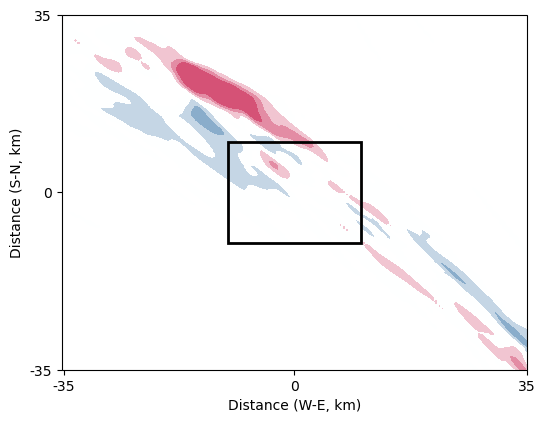

In [14]:
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('blue_white_red', [(81/255,132/255,178/255), 'white', (213/255,82/255,118/255)])
bounds = [-32, -24, -16,-8, 8,16, 24, 32]
norm = mcolors.BoundaryNorm(boundaries= [-32, -24, -16,-8, 8,16, 24, 32], ncolors=cmap.N)

def rain_difference(ax, data2,setlabel  = True):
    data = cases[0]
    lats, lons = data.lat[50:250, 50:250], data.lon[50:250, 50:250]
    
    # Set the extent for the map
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
    
    # Create a rectangle patch
    rect = patches.Rectangle((lons[80, 80], lats[80, 80]), lons[120, 120] - lons[80, 80], 
                             lats[170, 170] - lats[130, 130], linewidth=2, edgecolor='k', facecolor='none')
    
    # Calculate the difference in rain
    rain = data["RAINNC"][-1, 50:250, 50:250] - data["RAINNC"][0, 50:250, 50:250]
    rain2 = data2["RAINNC"][-1, 50:250, 50:250] - data2["RAINNC"][0, 50:250, 50:250]
    rain = rain2 - rain
    print(np.mean(rain))
    
    # Filter rain data
    rain = np.where((rain <= 2) & (rain >= -2), np.nan, rain)
    rain = np.where((rain >= 30), 30, rain)
    
    # Plot the contour
    rain_contour = ax.contourf(lons, lats, rain, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # Set the final extent
    ax.set_extent([np.min(data.lon[80:220, 80:220]), np.max(data.lon[80:220, 80:220]), 
                   np.min(data.lat[80:220, 80:220]), np.max(data.lat[80:220, 80:220])], crs=ccrs.PlateCarree())
    
    # Add rectangle patch
    ax.add_patch(rect)
    
    # # Print lat/lon values for debugging
    # print(lats.values[50, 50], lats.values[250, 250], lons.values[50, 50], lons.values[250, 250])
    if setlabel  == True:
    # Set x and y labels
        ax.set_xlabel('Distance (W-E, km)')
        ax.set_ylabel('Distance (S-N, km)')
        ax.set_xticks([data.lon[80, 80],data.lon[150,150],data.lon[220, 220]])
        ax.set_yticks([data.lat[80, 80],data.lat[150,150],data.lat[220, 220]],)
        ax.set_xticklabels(["-35","0","35"])  # Adjust according to your desired ticks
        ax.set_yticklabels(["-35","0","35"])  # Adjust according to your desired ticks
    else:
        ax.set_xlabel('Distance (W-E, km)')
        # ax.set_ylabel('Distance (S-N, km)')
        ax.set_xticks([data.lon[80, 80],data.lon[150,150],data.lon[220, 220]])
        ax.set_yticks([data.lat[80, 80],data.lat[150,150],data.lat[220, 220]],)
        ax.set_xticklabels(["-35","0","35"])  # Adjust according to your desired ticks
        ax.set_yticklabels(["-35","0","35"])  # Adjust according to your desired ticks
    
    

    
    return ax, rain_contour

fig, ax = plt.subplots(
    1, 1,  
    figsize=(6, 6),  
    subplot_kw={'projection': ccrs.PlateCarree()},
)
ax ,rain_contour= rain_difference(ax,cases[1])

## PDF of precipitation intensity

16.88504
18.04673


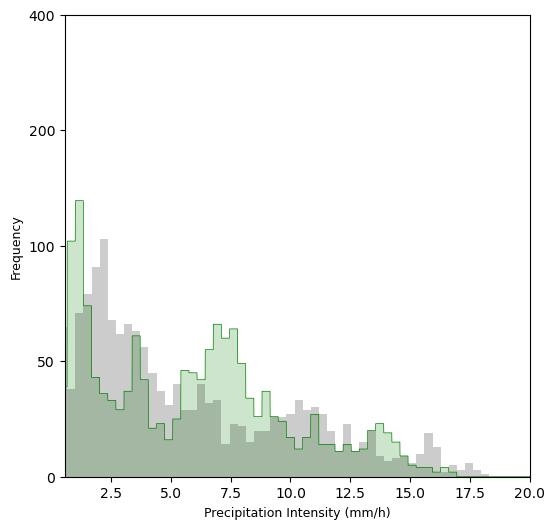

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def transform_y(y):
    if y == 0:
        return 0
    elif y == 50:
        return 1
    elif y == 100:
        return 2
    elif y == 200:
        return 3
    elif y == 400:
        return 4
    else:
        return np.interp(y, [0, 50, 100, 200, 400], [0, 1, 2, 3, 4])


def inverse_transform_y(y_scaled):
    return np.interp(y_scaled, [0, 1, 2, 3, 4], [0, 50, 100, 200, 400])
def generate_alternating_sequence(n):
    return [i % 2*(1/3) for i in range(n)]

def plot_distribution(ax, data, bins=np.linspace(0, 30, 60), color_for_urbanbar="g"):
    # Urban case data processing
    data = data["RAINNC"][-1, 130:170, 130:170] - data["RAINNC"][0, 130:170, 130:170]
    data = data /4
    data = data.values.flatten()
    print(np.max(data))
    data[data<0.1] =np.nan
    df = pd.DataFrame(data, columns=["RAINNC"])


    hist, bin_edges = np.histogram(df["RAINNC"], bins=bins)
    

    transformed_hist = np.array([transform_y(y) for y in hist])


    ax.bar(bin_edges[:-1], transformed_hist, width=np.diff(bin_edges), align='edge', alpha=0.2, color=color_for_urbanbar)
    # print(len([item for item in back_bin_edges[:-1] for _ in range(2)]+generate_alternating_sequence(118)))
    itemlist = [item for item in bin_edges[:-1] for _ in range(2)]
    ax.plot([x + y for x, y in zip(itemlist, generate_alternating_sequence(118))],[item for item in transformed_hist for _ in range(2)],c = "g",linewidth=0.5)
    # Rural case data processing
    back_data = rural_case["RAINNC"][-1, 130:170, 130:170] - rural_case["RAINNC"][0, 130:170, 130:170]
    back_data = back_data.values.flatten()
    back_data = back_data /4
    print(np.max(back_data))
    back_data[back_data<0.5] =np.nan
    
   
    back_df = pd.DataFrame(back_data, columns=["RAINNC"])
    back_hist, back_bin_edges = np.histogram(back_df["RAINNC"], bins=bins)
    # print(back_hist[:5])
    
    transformed_back_hist = np.array([transform_y(y) for y in back_hist])
    ax.bar(back_bin_edges[:-1], transformed_back_hist, width=np.diff(back_bin_edges), align='edge', alpha=0.2, color="k")
    ax.set_xlim(0.58, 20)
    ax.set_ylim(0, 4)  
    # print(len([item for item in back_bin_edges[:-1] for _ in range(2)]+generate_alternating_sequence(118)))
    itemlist = [item for item in back_bin_edges[:-1] for _ in range(2)]
    ax.set_yticks([0, 1, 2, 3, 4])


    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{int(inverse_transform_y(x))}'))


    ax.set_xlabel("Precipitation Intensity (mm/h)", fontsize=9)
    ax.set_ylabel("Frequency", fontsize=9)
    


    return ax
fig, ax = plt.subplots(
    1, 1,  
    figsize=(6, 6),  
)
ax = plot_distribution(ax,cases[3], bins=np.linspace(0, 20, 60))

## Fig.6

<xarray.DataArray 'RAINNC' ()> Size: 4B
array(0.00463931, dtype=float32)
Bbox(x0=0.125, y0=0.4752115392102977, x1=0.3529411764705882, y1=0.7731437239475971)
<xarray.DataArray 'RAINNC' ()> Size: 4B
array(-0.45709425, dtype=float32)
Bbox(x0=0.3985294117647059, y0=0.4752115392102977, x1=0.6264705882352941, y1=0.7731437239475971)
<xarray.DataArray 'RAINNC' ()> Size: 4B
array(-0.27776062, dtype=float32)
Bbox(x0=0.6720588235294118, y0=0.4752115392102977, x1=0.9, y1=0.7731437239475971)
15.156903
18.04673
Bbox(x0=0.125, y0=0.1100000000000001, x1=0.3529411764705882, y1=0.3632894736842106)
7.399729
18.04673
Bbox(x0=0.3985294117647059, y0=0.1100000000000001, x1=0.6264705882352941, y1=0.3632894736842106)
16.88504
18.04673
Bbox(x0=0.6720588235294118, y0=0.1100000000000001, x1=0.9, y1=0.3632894736842106)


C:\Users\32952\AppData\Local\Temp\ipykernel_22560\3559404471.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap4 = mpl.cm.get_cmap('viridis', nbin)


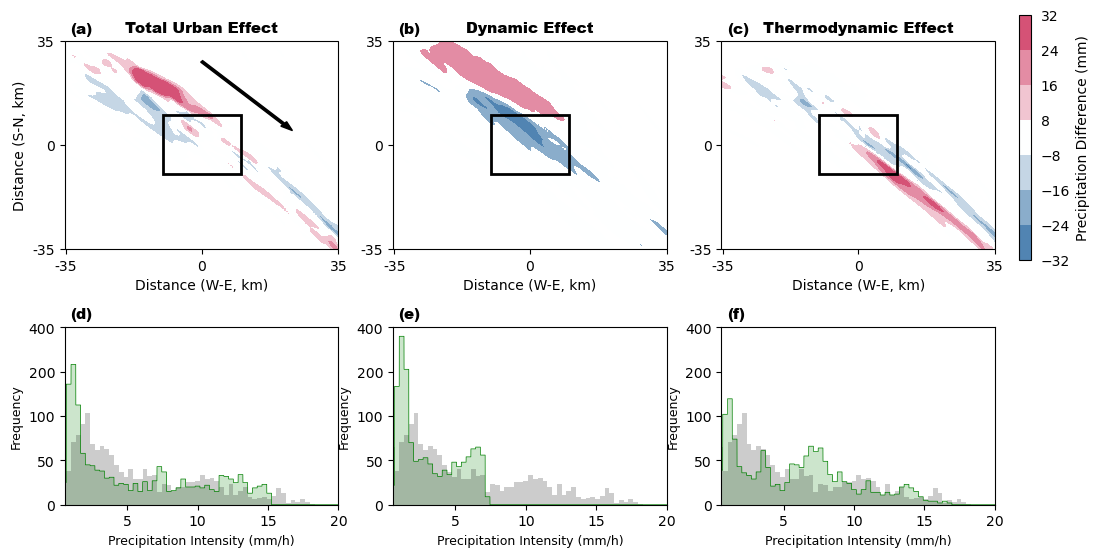

In [16]:
dict_title_cfg = dict(fontsize=11, fontweight="heavy", ha="left", fontfamily="Arial")
colorlist = [(132/255,145/255,180/255),
             (243/255,155/255,127/255),
             (145/255,209/255,194/255)]
colorlist=["g","g","g"]
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(3, 3,  hspace=0.02)
title_name =['Total Urban Effect',
    'Dynamic Effect',
    'Thermodynamic Effect',]
abcd_list = ["(a)","(b)","(c)","(d)","(e)","(f)"]
for i in range(3):
    
    if i ==0:
        ax = fig.add_subplot(gs[0:2, i:i+1],  projection=ccrs.PlateCarree())
        ax,colobar = rain_difference(ax,cases[i+1])
        ax.set_title(title_name[i],dict(fontsize=11, fontweight="heavy", ha="center", fontfamily="Arial"))
        ax.text(0.02,1.035, abcd_list[i], **dict_title_cfg, transform=ax.transAxes)
        print(ax.get_position())
        ax.arrow(0.5,0.9,  0.3, -0.3, width=0.01,color = "k",transform=ax.transAxes)
    else:
        ax = fig.add_subplot(gs[0:2, i:i+1],  projection=ccrs.PlateCarree())
        ax,colobar = rain_difference(ax,cases[i+1],setlabel=False)
        ax.set_title(title_name[i],dict(fontsize=11, fontweight="heavy", ha="center", fontfamily="Arial"))
        ax.text(0.02,1.035, abcd_list[i], **dict_title_cfg, transform=ax.transAxes)
        print(ax.get_position())

for i in range(3):
    ax = fig.add_subplot(gs[2, i:i+1])
    ax = plot_distribution(ax,cases[i+1],color_for_urbanbar = colorlist[i], bins=np.linspace(0, 20, 60))
    ax.text(0.02,1.05, abcd_list[i+3], **dict_title_cfg, transform=ax.transAxes)
    print(ax.get_position())
position=fig.add_axes([0.92, 0.46, 0.01, 0.35])

import matplotlib as mpl
bins = [0, 1, 10, 20, 50, 100]
nbin = len(bins) - 1
cmap4 = mpl.cm.get_cmap('viridis', nbin)
norm4 = mpl.colors.BoundaryNorm(bins, nbin)
im4 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(im4,cax=position,
             label = "Precipitation Difference (mm)",)
cbar_ticks = cbar.ax.yaxis.get_ticklines()
for tick in cbar_ticks:
    tick.set_visible(False) 
cbar.ax.yaxis.set_ticks_position('none')
# import matplotlib.lines as mlines
# line = mlines.Line2D([0.1965, 0.125], [0.54,0.3632894736842106], color='k', linestyle='--',linewidth=1.2)
# line2 = mlines.Line2D([0.268, 0.3529], [0.54,0.3632894736842106], color='k', linestyle='--',linewidth=1.2)

# fig.add_artist(line)
# fig.add_artist(line2)
